# Analysis

This script contains the code required to analyse and compare several CNN models against MetOffice Rainfall.

In [1]:
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
regions = ["ES","NS", "WS","EM","EE","LD","NEE","NWE","SEE","SWE","WAL","WM","YH"]

## Data Acquisition (Validation Only)

First, data and models need extracting. The MetOffice and benchmark (CEH-GEAR) data is first to be extracted.

In [42]:
all_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/expected_all.npy"
benchmark_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/expected_valid.npy"
mo_rf = "D:/PHD_DATA/Video_11-02-2021/prepared-data/mo_valid.npy"

all_rf = np.load(all_rf)[:, 2:]
benchmark_rf = np.load(benchmark_rf)[:, 2:]
mo_rf = np.load(mo_rf)[:, 2:]

In [43]:
def get_video_data():
    videos = "D:/PHD_DATA/Video_11-02-2021/prepared-data/middle_valid.npy"
    videos = np.load(videos)
    videos = np.swapaxes(videos, 1, 2)
    videos = np.swapaxes(videos, 2, 3)
    videos = np.swapaxes(videos, 3, 4)
    videos[:, :, :, :, 0] = (videos[:, :, :, :, 0] - np.mean(videos[:, :, :, :, 0])) / (np.std(videos[:, :, :, :, 0]))
    videos[:, :, :, :, 1] = (videos[:, :, :, :, 1] - np.mean(videos[:, :, :, :, 1])) / (np.std(videos[:, :, :, :, 1]))
    return videos

def get_frame_data():
    frame = "D:/PHD_DATA/Video_11-02-2021/prepared-data/single_valid.npy"
    frame = np.load(frame)
    frame = np.swapaxes(frame, 1, 2)
    frame = np.swapaxes(frame, 2, 3)
    frame[:, :, :, 0] = (frame[:, :, :, 0] - np.mean(frame[:, :, :, 0])) / (np.std(frame[:, :, :, 0]))
    frame[:, :, :, 1] = (frame[:, :, :, 1] - np.mean(frame[:, :, :, 1])) / (np.std(frame[:, :, :, 1]))
    return frame

In [44]:
videos = get_video_data()
frames = get_frame_data()

Next, the best performing models are selected and loaded.

In [45]:
single_frame_models = ["ES-1613144925","NS-1613145487","WS-1613145925","EM-1613146122","EE-1613146475","LD-1613146544",
                       "NEE-1613146804","NWE-1613147122","SEE-1613147399","SWE-1613147550","WAL-1613147584",
                       "WM-1613147875","YH-1613148002"]
slow_fusion_models = ["ES-1613065474","NS-1613068975","WS-1613071908","EM-1613074818","EE-1613079692","LD-1613082862",
                      "NEE-1613085567","NWE-1613087292","SEE-1613088892","SWE-1613121864","WAL-1613094356",
                      "WM-1613096188","YH-1613101007"]
earl_fusion_models = ["ES-1613391631","NS-1613405705","WS-1613469119","EM-1613488724","EE-1613518618","LD-1613548378",
                      "NEE-1613569618","NWE-1613588114","SEE-1613620883","SWE-1613646498","WAL-1613689774",
                      "WM-1613699686","YH-1613730530"]

In [46]:
def load_models(names, folder):
    models = []
    for n in tqdm(names):
        models.append(load_model(folder + n + ".mdl"))
    return models

In [8]:
single_frame_models = load_models(single_frame_models, folder="D:/PHD_DATA/Video_11-02-2021/SingleFrame/models/")
slow_fusion_models = load_models(slow_fusion_models, folder="D:/PHD_DATA/Video_11-02-2021/SlowFusion/models/")
early_fusion_models = load_models(earl_fusion_models, folder="D:/PHD_DATA/Video_11-02-2021/EarlyFusion/models/")

## Evaluation

Next, each model is evaluated by taking the RMSE for each region and comparing this to the MetOffice's RMSE.

In [47]:
reevaluate = False

In [48]:
def get_predictions(models, inputs, regions):
    """ Generates a matrix of predictions for the given model set.
        Params:
            models - A set of tensorflow models in the same order as regions.
    """
    predictions = []
    for ridx, r in tqdm(enumerate(regions), total=len(regions)):
        model_preds = []
        for iidx, v in enumerate(inputs):
            model_preds.append(
                models[ridx](np.expand_dims(v, 0))
            )
        predictions.append(model_preds)
    return np.array(predictions)

In [54]:
if reevaluate:
    single_frame_predictions = get_predictions(single_frame_models, frames, regions).squeeze()
    slow_fusion_predictions = get_predictions(slow_fusion_models, videos, regions).squeeze()
    early_fusion_predictions = get_predictions(early_fusion_models, videos, regions).squeeze()
else:
    single_frame_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/single-frame.npy")
    slow_fusion_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/slow-fusion.npy")
    early_fusion_predictions = np.load("D:/PHD_DATA/Video_11-02-2021/predictions/early-fusion.npy")

# Unnormalize
for ridx, r in enumerate(regions):
    single_frame_predictions[ridx, :] = (single_frame_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])
    slow_fusion_predictions[ridx, :] = (slow_fusion_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])
    early_fusion_predictions[ridx, :] = (early_fusion_predictions[ridx, :] * (np.max(all_rf[:, ridx]) - np.min(all_rf[:, ridx]))) + np.min(all_rf[:, ridx])

In [55]:
single_frame_predictions.shape

(13, 84)

Now we have the predictions it's time to plot the RMSEs for each region.

In [56]:
def get_rmses(model_predictions, mo_preds, benchmark, regions):
    ## RMSES
    # 0: Single Frame
    # 1: Slow Fusion
    # 2: Early Fusion
    # 3: Met Office
    ##
    rmses = np.zeros((len(regions), len(model_predictions) + 1))
    for ridx, r in enumerate(regions):
        for midx, m in enumerate(model_predictions):
            rmses[ridx, midx] = np.sqrt(np.mean(np.power((benchmark_rf[:, ridx] - m[ridx, :]), 2)))
        rmses[ridx, -1] = np.sqrt(np.mean(np.power((benchmark_rf[:, ridx] - mo_rf[:, ridx]), 2)))
    return rmses
rmses = get_rmses([single_frame_predictions, slow_fusion_predictions, early_fusion_predictions], mo_rf, benchmark_rf, regions)

In [58]:
rmses.shape

(13, 4)

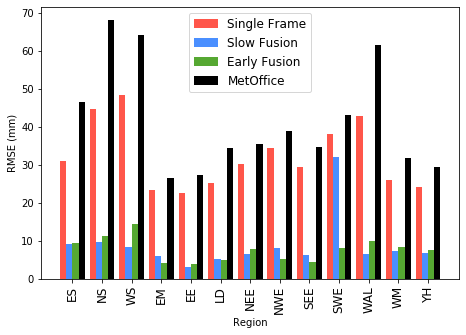

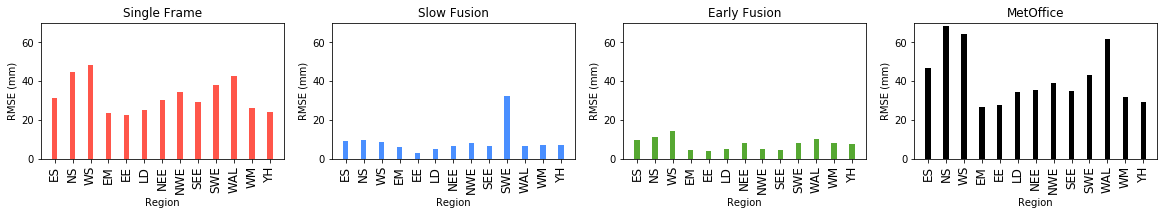

In [99]:
def plot_rmses_one(rmses, labels, regions):
    plt.rcParams['figure.figsize'] = [7.5, 5]
    fig, axs = plt.subplots(nrows=1, ncols=1)
    width = 0.25
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    bars = [None, None, None, None]
    positions = [-width*1.5, -width/2, width/2, width*1.5]
    xs = []
    
    for ridx, r in enumerate(regions):
        for rmseidx, rmse in enumerate(rmses[ridx, :]):
            bars[rmseidx] = axs.bar(
                ridx+positions[rmseidx]+0.2*ridx,
                rmse,
                color=colours[rmseidx],
                width=width,
                label=labels[rmseidx]
            )
        xs.append(ridx+0.2*ridx)
    axs.set_ylabel("RMSE (mm)")
    axs.set_xlabel("Region")
    
    axs.set_xticks(xs)
    axs.set_xticklabels(regions, rotation=90, fontsize=12)
    
    axs.legend(bars, labels, fontsize=12)

def plot_rmses_several(rmses, labels, regions):
    plt.rcParams['figure.figsize'] = [5*rmses.shape[1], 2.5]
    fig, axs = plt.subplots(nrows=1, ncols=rmses.shape[1])
    width = 0.3
    colours = ['#ff564a', '#4a8fff', '#56a832', 'k']
    
    for rmseidx in range(0, rmses.shape[1]):
        for ridx, r in enumerate(regions):
            axs[rmseidx].bar(
                ridx,
                rmses[ridx, rmseidx],
                color=colours[rmseidx],
                width=width,
                label=labels[rmseidx]
            )
        
        axs[rmseidx].set_ylabel("RMSE (mm)")
        axs[rmseidx].set_xlabel("Region")

        axs[rmseidx].set_xticks(range(0, 13))
        axs[rmseidx].set_xticklabels(regions, rotation=90, fontsize=12)
        axs[rmseidx].set_title(labels[rmseidx])    
        
        axs[rmseidx].set_ylim([0, 70])
plot_rmses(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], regions)
plot_rmses_several(rmses, ["Single Frame", "Slow Fusion", "Early Fusion", "MetOffice"], regions)